In [2]:
import os
import json
base_path = "/datasets/mvtec"

train_file = f"{base_path}/mvtec_screws_train.json"
val_file = f"{base_path}/mvtec_screws_val.json"
test_file = f"{base_path}/mvtec_screws_test.json"
category_names = {7:'nut', 3:'wood_screw', 2:'lag_wood_screw', 8:'bolt',
                  6:'black_oxide_screw', 5:'shiny_screw', 4:'short_wood_screw',
                  1:'long_lag_screw', 9:'large_nut', 11:'nut2', 10:'nut1',
                  12:'machine_screw', 13:'short_machine_screw' }

import numpy as np

def get_xywha_for_write(file):
    label_file = json.load(open(file, "r"))
    
    image_name_lines = {}
    image_id_names = {}
    for img in label_file["images"]:
        image_name_lines[img["file_name"]] = []
        image_id_names[img["id"]] = img["file_name"]
    
    for ant in label_file["annotations"]:
        category_id = ant["category_id"]
        image_id = ant["image_id"]
        ant_id = ant["id"]
        
        # cx, cy가 아닌 cy, cx로 레이블링 되어있음
        cy, cx, w, h, a = ant["bbox"]
        
        # angle은 (-π, π] 라고 했는데, 해당 범위를 넘어가는 데이터가 존재하므로 
        # (-π, π] 범위로 재조정
        if a < 0:
            a += 2 * np.pi
        
        assert 0 <= a < 2 * np.pi  # Ensure t is in the range [0, 2π)

        a = np.rad2deg(a) # degree로 변환
        if np.isclose(a, 360, atol=0.5):
            a = 0

        label = category_names[category_id]
        
        # (obb) + (label) + (difficulty)
        line = "%d %d %d %d %f %s %d" % (cx, cy, w, h, a, label, 0)
        image_name_lines[image_id_names[image_id]].append(line)
    return image_name_lines

train_image_name_lines = get_xywha_for_write(train_file)
val_image_name_lines = get_xywha_for_write(val_file)
test_image_name_lines = get_xywha_for_write(test_file)



In [3]:
def write_to_labels(image_name_lines):
    os.makedirs(f"{base_path}/annfiles", exist_ok=True)
    for image_name, lines in image_name_lines.items():
        txt_path = os.path.join(f"{base_path}/annfiles", image_name.rstrip(".png")+".txt")
        with open(txt_path, "w") as f:
            for line in lines:
                f.writelines(line + "\n")
write_to_labels(train_image_name_lines)
write_to_labels(val_image_name_lines)
write_to_labels(test_image_name_lines)   

In [4]:
import glob 
import shutil

anns_path = f"{base_path}/annfiles"
imgs_path = f"{base_path}/images"
trainval_path = f"{base_path}/trainval"
test_path = f"{base_path}/test"
import os
trainval_imgs_path = os.path.join(trainval_path, "images")
trainval_anns_path = os.path.join(trainval_path, "annfiles")
test_imgs_path = os.path.join(test_path, "images")
test_anns_path = os.path.join(test_path, "annfiles")

os.makedirs(trainval_imgs_path, exist_ok=True)
os.makedirs(trainval_anns_path, exist_ok=True)
os.makedirs(test_imgs_path, exist_ok=True)
os.makedirs(test_anns_path, exist_ok=True)

txtfiles = glob.glob(f"{base_path}/annfiles/*.txt")
import random
random.shuffle(txtfiles)
imgfiles = [txtfile.replace("annfiles", "images").replace(".txt", ".png") for txtfile in txtfiles]

n = len(txtfiles)
n_train = int(n*0.8)

In [5]:
train_txtfiles = txtfiles[:n_train]
train_imgfiles = imgfiles[:n_train]

for train_txtfile, train_imgfile in zip(train_txtfiles, train_imgfiles):
    txtfilename = train_txtfile.split("/")[-1]
    imgfilename = train_imgfile.split("/")[-1]
    shutil.copy(train_txtfile, os.path.join(trainval_anns_path, txtfilename))
    shutil.copy(train_imgfile, os.path.join(trainval_imgs_path, imgfilename))
    
test_txtfiles = txtfiles[n_train:]
test_imgfiles = imgfiles[n_train:]

for test_txtfile, test_imgfile in zip(test_txtfiles, test_imgfiles):
    txtfilename = test_txtfile.split("/")[-1]
    imgfilename = test_imgfile.split("/")[-1]
    shutil.copy(test_txtfile, os.path.join(test_anns_path, txtfilename))
    shutil.copy(test_imgfile, os.path.join(test_imgs_path, imgfilename))

In [6]:
import sys
sys.path.append("..")
from datasets.mvtec import MVTecDataset
data = MVTecDataset(
    "/workspace/datasets/mvtec.pth", 
    base_path, 
    split="train"
)

[DATA] /workspace/datasets/mvtec.pth not found, creating...


Loading annotations: 100%|██████████| 77/77 [00:00<00:00, 4146.96it/s]


In [14]:
angles = []
for image, target in data:
    obox = target['oboxes']
    angle = obox[:, -1]
    angles.extend(angle.tolist())

(array([576.,  22.,  17.,  18.,  25.,  26.,  28.,  28.,  23.,  22.,  32.,
         22.,  27.,  30.,  35.,  35.,  52.,  48.,  41.,  46.,  47.,  47.,
         63.,  48.,  50.,  53.,  50.,  40.,  34.,  49.,  31.,  40.,  33.,
         26.,  32.,  30.,  36.,  17.,  17.,  28.,  26.,  28.,  22.,  19.,
         16.,  20.,  22.,  15.,  16.,  18.,  24.,  26.,  13.,  22.,  17.,
         18.,  31.,  21.,  19.,  16.,  21.,  15.,  15.,  13.,  23.,  15.,
         17.,  17.,  13.,  16.,  24.,  16.,  16.,  15.,  24.,  23.,  12.,
         15.,  19.,  17.,  14.,  23.,  12.,   8.,   7.,  15.,  14.,   8.,
         11.,  23.,  17.,  16.,  10.,  14.,  18.,  21.,  17.,  14.,  24.,
        547.]),
 array([  0.        ,   3.59999756,   7.19999512,  10.79999268,
         14.39999023,  17.99998779,  21.59998535,  25.19998291,
         28.79998047,  32.39997803,  35.99997559,  39.59997314,
         43.1999707 ,  46.79996826,  50.39996582,  53.99996338,
         57.59996094,  61.1999585 ,  64.79995605,  68.39995361

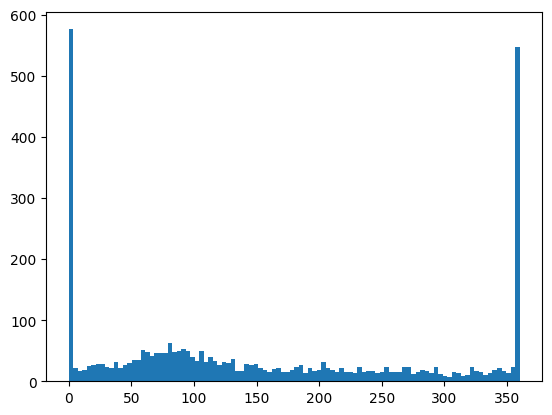

In [15]:
import matplotlib.pyplot as plt
plt.hist(angles, bins=100)

In [16]:
from torchvision.transforms.functional import to_pil_image
os.makedirs("/datasets/mvtec/rrois/train", exist_ok=True)
for tensor_image, target in data:
    oboxes, polys = target["oboxes"], target["polygons"]
    image_path = target["image_path"]
    image_name = image_path.split("/")[-1].split(".")[0]

    # use image as feature
    feature = {"0": tensor_image.unsqueeze(0)}
    from ops.poolers import MultiScaleRotatedRoIAlign
    rroi_align = MultiScaleRotatedRoIAlign(["0"], output_size = 200, sampling_ratio=2, canonical_scale=224, canonical_level=4)
    rrois = rroi_align(feature, [oboxes], image_shapes=[[1920, 1440]])
    pil_rrois = list(map(to_pil_image, rrois))
    for i, (obox, poly, pil_rroi) in enumerate(zip(oboxes, polys, pil_rrois)):
        obox_imagename = str(obox.tolist()) + "_" + image_name + ".png"
        pil_rroi.save(os.path.join("/datasets/mvtec/rrois/train", obox_imagename))

(array([10010., 10010., 10010., 10010., 10010., 10010., 10010., 10010.,
        10010., 10010., 10010., 10010., 10010., 10010., 10010., 10010.,
        10010., 10010., 10010., 10010., 10010., 10010., 10010., 10010.,
        10010., 10010., 10010., 10010., 10010., 10010., 10010., 10010.,
        10010., 10010., 10010., 10010., 10010., 10010., 10010., 10010.,
        10010., 10010., 10010., 10010., 10010., 10010., 10010., 10010.,
        10010.,  9009., 10011., 10010., 10010., 10010., 10010., 10010.,
        10010., 10010., 10010., 10010., 10010., 10010., 10010., 10010.,
        10010., 10010., 10010., 10010., 10010., 10010., 10010., 10010.,
        10010., 10010., 10010., 10010., 10010., 10010., 10010., 10010.,
        10010., 10010., 10010., 10010., 10010., 10010., 10010., 10010.,
        10010., 10010., 10010., 10010., 10010., 10010., 10010., 10010.,
        10010., 10010., 10010., 10010.]),
 array([-179.81981982, -176.22342342, -172.62702703, -169.03063063,
        -165.43423423, -16

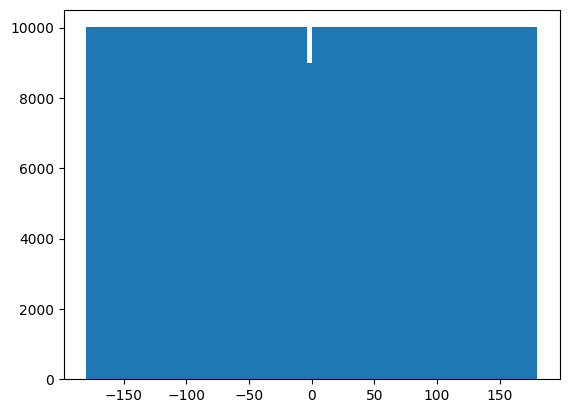

In [21]:
import numpy as np
import matplotlib.pyplot as plt
phi = np.linspace(0, 360, 1000)
phi_star = phi.copy()

d_phi = lambda a, b: a-b if np.abs(a-b) < 180 else a-b-360 *np.sign(a-b)
data = []

for p in phi:
    for ps in phi_star:
        d = d_phi(p, ps)
        data.append(d)
plt.hist(data, bins=100)

In [19]:
import torch
x, y = 0.8, 0.8
x /= torch.norm(torch.tensor([x, y]))
y /= torch.norm(torch.tensor([x, y]))
a = torch.rad2deg(torch.atan2(torch.tensor([x]), torch.tensor([y])))

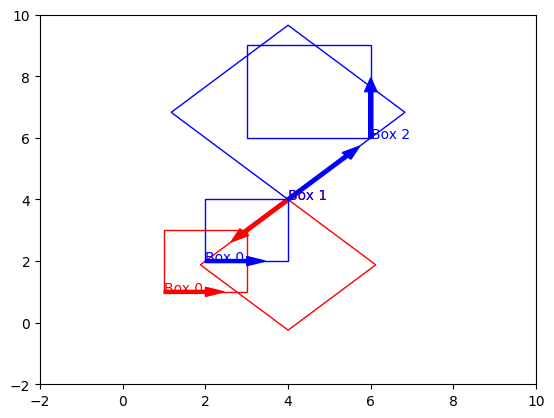

Boxes1 0 vs Boxes2 0: 0.1428571492433548
Boxes1 0 vs Boxes2 1: 0.0
Boxes1 0 vs Boxes2 2: 0.0
Boxes1 1 vs Boxes2 0: 0.0005664207274094224
Boxes1 1 vs Boxes2 1: 0.5624999403953552
Boxes1 1 vs Boxes2 2: 0.03619065880775452
tensor([[0.1429, 0.0000, 0.0000],
        [0.0006, 0.5625, 0.0362]])


In [26]:
# Import necessary modules
import numpy as np
import torch
from detectron2._C import box_iou_rotated
# Create test tensors
boxes1 = torch.tensor([[1, 1, 2, 2, 0], [4, 4, 3, 3, 225]]).float()
boxes2 = torch.tensor([[2, 2, 2, 2, 0], [4, 4, 4, 4, 45], [6, 6, 3, 3, 90]]).float()
import matplotlib.pyplot as plt


# Plot the boxes
fig, ax = plt.subplots()
for i, box in enumerate(boxes1):
    rect = plt.Rectangle((box[0], box[1]), box[2], box[3], angle=box[4], edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    # Add arrow to indicate direction
    arrow_length = 0.5 * max(box[2], box[3])
    arrow_dx = arrow_length * np.cos(np.deg2rad(box[4]))
    arrow_dy = arrow_length * np.sin(np.deg2rad(box[4]))
    ax.arrow(box[0], box[1], arrow_dx, arrow_dy, color='r', width=0.1)
    ax.text(box[0], box[1], f'Box {i}', color='r')
    
for i, box in enumerate(boxes2):
    rect = plt.Rectangle((box[0], box[1]), box[2], box[3], angle=box[4], edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    # Add arrow to indicate direction
    arrow_length = 0.5 * max(box[2], box[3])
    arrow_dx = arrow_length * np.cos(np.deg2rad(box[4]))
    arrow_dy = arrow_length * np.sin(np.deg2rad(box[4]))
    ax.arrow(box[0], box[1], arrow_dx, arrow_dy, color='b', width=0.1)
    ax.text(box[0], box[1], f'Box {i}', color='b')
# Set plot limits
ax.set_xlim(-2, 10)
ax.set_ylim(-2, 10)

# Show the plot
plt.show()

# Calculate IoU
iou = box_iou_rotated(boxes1, boxes2, False)
for i in range(len(iou)):
    for j in range(len(iou[i])):
        print(f'Boxes1 {i} vs Boxes2 {j}: {iou[i][j]}')

# Print the result
print(iou)

In [25]:
import torch
from shapely.geometry import Polygon
from shapely.affinity import rotate, translate

def rect_to_polygon(rect):
    cx, cy, w, h, angle = rect
    # Rectangle centered at origin
    rect = Polygon([(-w/2, -h/2), (-w/2, h/2), (w/2, h/2), (w/2, -h/2)])
    # Rotate and translate the rectangle
    rotated = rotate(rect, angle, origin=(0, 0), use_radians=False)
    translated = translate(rotate(rotated, angle, 'center'),cx, cy)
    return translated

def calculate_iou(poly1, poly2):
    intersection = poly1.intersection(poly2).area
    union = poly1.union(poly2).area
    return intersection / union

# Convert tensors to numpy arrays
boxes1_np = boxes1.numpy()
boxes2_np = boxes2.numpy()

# Convert numpy arrays to polygons
polygons1 = [rect_to_polygon(rect) for rect in boxes1_np]
polygons2 = [rect_to_polygon(rect) for rect in boxes2_np]

# Calculate IoUs
ious = []
for i, poly1 in enumerate(polygons1):
    t = []
    for j, poly2 in enumerate(polygons2):
        iou = calculate_iou(poly1, poly2)
        t.append(iou)
    ious.append(t)

# ious now contains the IoU for each pair of rectangles
print(np.array(ious))


[[0.14285714 0.         0.        ]
 [0.01960784 0.5625     0.05882353]]
